# Deep Learning Explore. 

In [1]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Crear generadores de datos. 

In [3]:
import os
import shutil
import random

# Directorio donde están tus imágenes originales
original_data_dir = "../data/raw/train" 

# Directorio de destino para la nueva estructura
base_dir = "../data/raw/dataset"

# Porcentaje de imágenes para el conjunto de validación
validation_split = 0.2

# Crear la estructura de carpetas
try:
    os.makedirs(os.path.join(base_dir, 'train', 'cat'))
    os.makedirs(os.path.join(base_dir, 'train', 'dog'))
    os.makedirs(os.path.join(base_dir, 'validation', 'cat'))
    os.makedirs(os.path.join(base_dir, 'validation', 'dog'))
    print("Estructura de carpetas creada exitosamente.")
except FileExistsError:
    print("La estructura de carpetas ya existe. Continuando...")

# Obtener la lista de todos los archivos de imágenes
file_names = os.listdir(original_data_dir)
random.shuffle(file_names) # Mezclar la lista para una división aleatoria

# Dividir los archivos en conjuntos de entrenamiento y validación
split_index = int(len(file_names) * (1 - validation_split))
train_files = file_names[:split_index]
validation_files = file_names[split_index:]

print(f"\nTotal de imágenes encontradas: {len(file_names)}")
print(f"Imágenes para entrenamiento: {len(train_files)}")
print(f"Imágenes para validación: {len(validation_files)}")

# Mover archivos al directorio de entrenamiento
print("\nMoviendo archivos de entrenamiento...")
for file_name in train_files:
    if file_name.startswith('cat'):
        shutil.copy(os.path.join(original_data_dir, file_name), os.path.join(base_dir, 'train', 'cat', file_name))
    elif file_name.startswith('dog'):
        shutil.copy(os.path.join(original_data_dir, file_name), os.path.join(base_dir, 'train', 'dog', file_name))

# Mover archivos al directorio de validación
print("Moviendo archivos de validación...")
for file_name in validation_files:
    if file_name.startswith('cat'):
        shutil.copy(os.path.join(original_data_dir, file_name), os.path.join(base_dir, 'validation', 'cat', file_name))
    elif file_name.startswith('dog'):
        shutil.copy(os.path.join(original_data_dir, file_name), os.path.join(base_dir, 'validation', 'dog', file_name))

print("\n¡Organización de archivos completa!")

Estructura de carpetas creada exitosamente.

Total de imágenes encontradas: 25000
Imágenes para entrenamiento: 20000
Imágenes para validación: 5000

Moviendo archivos de entrenamiento...
Moviendo archivos de validación...

¡Organización de archivos completa!


In [4]:
# Definir las rutas de las carpetas
train_dir = '../data/raw/dataset/train'
validation_dir = '../data/raw/dataset/validation'

# Definir los parámetros para el preprocesamiento de imágenes
IMG_WIDTH = 200
IMG_HEIGHT = 200
BATCH_SIZE = 32

# Crear el objeto ImageDataGenerator para los datos de entrenamiento
# trdata (entrenamiento) con aumento de datos
trdata = ImageDataGenerator(
    rescale=1./255,           # Normalizar los valores de píxel
    rotation_range=40,        # Aumento de datos para el entrenamiento
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Crear el objeto ImageDataGenerator para los datos de validación/prueba
# tsdata (validación), solo escalado
tsdata = ImageDataGenerator(rescale=1./255)

# Pasa la carpeta de entrenamiento al objeto trdata
# El generador de entrenamiento etiquetará automáticamente las imágenes
train_generator = trdata.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),  # Redimensionar a 200x200
    batch_size=BATCH_SIZE,
    class_mode='binary'                   # 'binary' para dos clases (gato, perro)
)

# Pasa la carpeta de validación al objeto tsdata
# El generador de validación etiquetará las imágenes de prueba
validation_generator = tsdata.flow_from_directory(
    validation_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Opcional: Imprimir las clases detectadas para verificar que todo esté bien
print("\nClases detectadas por el generador de entrenamiento:")
print(train_generator.class_indices)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.

Clases detectadas por el generador de entrenamiento:
{'cat': 0, 'dog': 1}


# 2. Entrenar modelo. 

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Crear un modelo secuencial
model = Sequential([
    # Primera capa convolucional y de pooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D(2, 2),

    # Segunda capa convolucional y de pooling
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Tercera capa convolucional y de pooling
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Aplanar las capas convolucionales
    Flatten(),

    # Capas densas (fully connected)
    Dense(512, activation='relu'),
    Dropout(0.5), # Capa de regularización para evitar el sobreajuste
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Mostrar un resumen de la arquitectura del modelo
model.summary()

/Users/bereniceramos/Documents/Personal/4Geeks/Deep Learning/deep_learning_project_BBRH/mi_entorno/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    34,669,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,762,817 (132.61 MB)

 Trainable params: 34,762,817 (132.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Entrenar el modelo
# 'steps_per_epoch' y 'validation_steps' se calculan para asegurar que se procesen
# todas las imágenes en cada epoch.
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15, # Puedes ajustar el número de epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

/Users/bereniceramos/Documents/Personal/4Geeks/Deep Learning/deep_learning_project_BBRH/mi_entorno/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 348s 555ms/step - accuracy: 0.5592 - loss: 0.6837 - val_accuracy: 0.5639 - val_loss: 0.6802
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 336s 537ms/step - accuracy: 0.5810 - loss: 0.6775 - val_accuracy: 0.6068 - val_loss: 0.6452
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 325s 520ms/step - accuracy: 0.6281 - loss: 0.6409 - val_accuracy: 0.6785 - val_loss: 0.6045
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 319s 510ms/step - accuracy: 0.6747 - loss: 0.6027 - val_accuracy: 0.7338 - val_loss: 0.5408
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 315s 504ms/step - accuracy: 0.7018 - loss: 0.5700 - val_accuracy: 0.7129 - val_loss: 0.6153
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 341s 545ms/step - accuracy: 0.7325 - loss: 0.5391 - val_accuracy: 0.7935 - val_loss: 0.4666
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 329s 526ms/step - accuracy: 0.7472 - loss: 0.5163 - val_accuracy: 0.8041 - val_loss: 0.4322
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 335s 536ms/step - accuracy: 0.7621 -

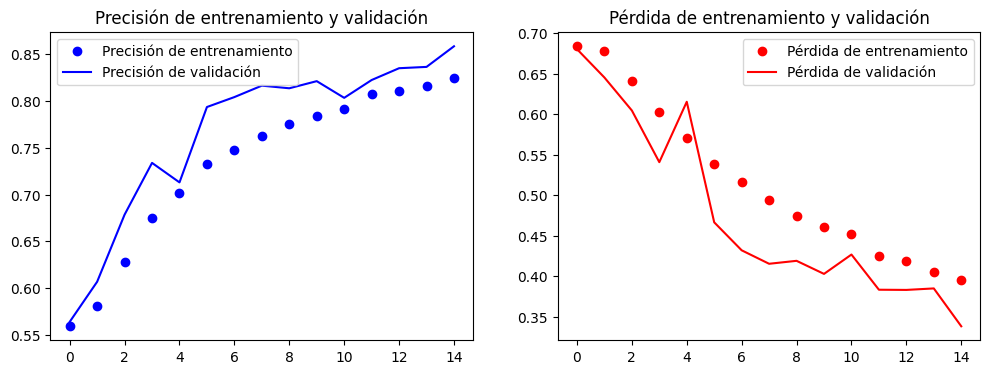

In [7]:
import matplotlib.pyplot as plt

# Obtener los datos del historial de entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Precisión de entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Precisión de validación')
plt.title('Precisión de entrenamiento y validación')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida de validación')
plt.title('Pérdida de entrenamiento y validación')
plt.legend()

plt.show()